In [1]:
import sys, os, subprocess, json, pickle, uproot
import numpy as np
import pandas as pd
import awkward as ak
from datetime import datetime
from tqdm import tqdm
from xgboost import XGBClassifier, plot_importance

from matplotlib import pyplot as plt
#import plotly.graph_objects as go

#import os #Only on RECAS JupyterLab Service
#os.environ['PATH'] += ':/lustrehome/fsimone/miniconda3/envs/root_env/bin' #Only on RECAS JupyterLab Service 
from ROOT import RDF

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0
C system headers (glibc/Xcode/Windows SDK) must be installed.
/lustrehome/fsimone/.conda/envs/my_kernel/etc/cling/std.modulemap:69:12: error: header 'compare' not found
    header "compare"
           ^
input_line_1:1:10: note: submodule of top-level module 'std' implicitly imported here
#include <new>
         ^
Warning in cling::IncrementalParser::CheckABICompatibility():
  Failed to extract C++ standard library version.
Replaced symbol at_quick_exit cannot be found in JIT!
In file included from input_line_4:36:
/../lib/gcc/x86_64-linux-gnu/9/../../../../include/c++/9/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~
IncrementalExecutor::executeFunction: symbol '_ZN5cling7runtime6gClingE

In [2]:
# set custom functions
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

def get_arrays(tree, branch_list):
    _dict = {}
    for _br in branch_list:
        _dict[_br] = getattr(tree[_br].arrays(), _br)
    return pd.DataFrame.from_dict(_dict)

def get_input_features(df, train_list, cuts=''):
    if cuts=='': return df[train_list].to_numpy()
    _df = df[df.eval(cuts)]
    return _df[train_list].to_numpy()

def plot_training_history(model, category, fold, metric):    
    results = model.evals_result()
    epochs = len(results['validation_0'][metric])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=(6.6,4.4))
    ax.plot(x_axis, results['validation_0'][metric], label='Train')
    ax.plot(x_axis, results['validation_1'][metric], label='Test')
    ax.legend(fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.title('{} (iFold={})'.format(category, fold), fontsize=16)
    plt.show()
    fig.savefig(out_dir+"/AUC_plot_"+category+"fold_"+str(fold)+".png")

def load_pkl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

def get_parameters(json_file, cat):
    """Get parameters for XGBoost"""
    parameters = json_file["xgb_parameters_"+cat]
    param = {}
    for entry in parameters:
        key = list(entry.keys())[0]
        value = entry[key]
        param[key] = value
    return param

In [3]:
# Open config File
config = "config_dsphipi.json"
with open(config, 'r') as file:
    json_file_temp = json.load(file)
    
output_folder = json_file_temp['output_folder']
try:
    label = json_file_temp['label']
except KeyError:
    label = ""

In [4]:
# Create new config File
date = datetime.now().strftime("%Y%m%d-%H%M%S")
out_dir = output_folder+"/"+label+"_"+date
if not os.path.exists(out_dir):
    subprocess.call("mkdir -p %s" % out_dir, shell=True)
config_out = out_dir+"/config.json"
json_file_temp["date"] = date
with open(config_out, 'w') as file:
    json.dump(json_file_temp, file, indent=2)

In [5]:
# Open new config File
with open(config_out, 'r') as file:
    json_file = json.load(file)

categories_list = json_file["categories"]
param = []
for c in categories_list:
    param_temp = get_parameters(json_file, c)
    param.append(param_temp)

In [6]:
# load data
input_files = json_file['input_files']
training_variables = json_file['training_variables']
spectator_variables = json_file['spectator_variables']
tree_name = json_file['tree_name']
dfs = []
for file in input_files:
    print("Loading data from ", file)
    file_temp = uproot.open(file)
    df_temp = get_arrays(file_temp[tree_name], training_variables+spectator_variables)
    dfs.append(df_temp)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
print(df['year'].unique())
del dfs

Loading data from  ../ROOTFiles/AllControl_chi2cut_plusMVA_sPlot.root
[2022. 2023.]


In [7]:
#make sure that weights are positive
index_branch = [json_file['index_branch']]
df[df < 0] = 1e-6

In [8]:
print(df['isMC'].unique())
df['isMC'] = df['isMC'].clip(lower=0)
print(df['isMC'].unique())

[0. 5.]
[0. 5.]


In [9]:
kFolds = json_file['number_of_splits']
try:
    weight_column = [json_file['weight_column']]
except KeyError:
    weight_column = None
X_list = []
y_list = []
weight_train_list = []
kfold_split_list = []

print(categories_list)
for cat in categories_list:
    try:
        bkg_sel = json_file[cat+"_bkg"]
    except KeyError:
        bkg_sel = ""
    try:
        sig_sel = json_file[cat+"_sig"]
    except KeyError:
        sig_sel = ""
    X_bkg_temp = get_input_features(df, training_variables, bkg_sel)
    X_sig_temp = get_input_features(df, training_variables, sig_sel)
    print("category ",cat," Data=",len(X_bkg_temp)," MC=",len(X_sig_temp))
    y_bkg_temp = np.zeros(len(X_bkg_temp))
    y_sig_temp = np.ones(len(X_sig_temp))
    
    bkg_eventNumber = get_input_features(df, index_branch, bkg_sel)
    sig_eventNumber = get_input_features(df, index_branch, sig_sel)

    if weight_column is not None:
        W_bkg_temp = get_input_features(df, weight_column, bkg_sel)
        W_sig_temp = get_input_features(df, weight_column, sig_sel)
        
        weight_train_list.append(np.concatenate((W_bkg_temp, W_sig_temp)))

    X_list.append(np.concatenate((X_bkg_temp, X_sig_temp)))
    y_list.append(np.concatenate((y_bkg_temp, y_sig_temp)))
    kfold_split_list.append(np.concatenate((bkg_eventNumber % kFolds, sig_eventNumber % kFolds)))


['Cat_full']
category  Cat_full  Data= 229769  MC= 253009


In [10]:
xgbcvclassifiers = {cat: [] for cat in categories_list}
print(xgbcvclassifiers)

{'Cat_full': []}


In [11]:
# fit models 
number_of_training = kFolds*len(categories_list)
with tqdm(total=number_of_training, desc="Training... ", bar_format="{desc}: {percentage:.0f}%|{bar:80}| {n}/{total} ") as progress_bar:
    for catID in range(len(categories_list)):
        for ifold in range(kFolds):
            X_train = X_list[catID][kfold_split_list[catID].flatten()!=ifold,:]
            Y_train = y_list[catID][kfold_split_list[catID].flatten()!=ifold]
            if weight_column is not None: 
                weights_train = weight_train_list[catID][kfold_split_list[catID].flatten()!=ifold]
            
            X_test = X_list[catID][kfold_split_list[catID].flatten()==ifold,:]
            Y_test = y_list[catID][kfold_split_list[catID].flatten()==ifold]
            
            model = XGBClassifier(**param[catID])

            if weight_column is not None:
                history = model.fit(X_train, Y_train,
                                    verbose               = 0,
                                    sample_weight = weights_train,
                                    eval_set=[(X_train, Y_train), (X_test, Y_test)]
                                   )
            else:
                history = model.fit(X_train, Y_train,
                                    verbose               = 0,
                                    eval_set=[(X_train, Y_train), (X_test, Y_test)]
                                   )
            
            xgbcvclassifiers[categories_list[catID]].append((model, history))
            #save model
            pickle.dump(model, open(out_dir+"/model_"+categories_list[catID]+"_fold"+str(ifold)+".pkl", "wb"))
            progress_bar.update(1)

Training... : 100%|████████████████████████████████████████████████████████████████████████████████| 10/10 


In [12]:
try:
    category_branch = json_file["category_branch"]
except KeyError:
    category_branch = "NO_category_temp"

print(category_branch)

NO_category_temp


In [13]:
df["kfoldID"] = (df[index_branch] % kFolds).astype(int)
all_input_X = get_input_features(df, training_variables, '')
try:
    category_branch = json_file["category_branch"]
except KeyError:
    category_branch = "NO_category_temp"

if(len(categories_list)==1 and category_branch == "NO_category_temp"):
    df[category_branch] = 0

bdt_scores = (df[category_branch]==0).to_numpy()*(0.0)
bdt_cv_scores = (df[category_branch]==0).to_numpy()*(0.0)
folds = []
for k in range(kFolds):
    folds.append((df[category_branch]==0).to_numpy()*(0.0))
    
for ic, category_ in enumerate(xgbcvclassifiers):
    for fold_ in range(kFolds):
        all_tmpscores = xgbcvclassifiers[category_][fold_][0].predict_proba(all_input_X)
        #MC probability #Data probability (1 - MC)
        mc_tmpscores = all_tmpscores[:, 0]
        bdt_scores += ((df[category_branch]==(ic)).to_numpy()*mc_tmpscores)/kFolds
        folds[fold_] += (df[category_branch]==(ic)).to_numpy()*mc_tmpscores 
        bdt_cv_scores += ((df[category_branch]==(ic)) & (df["kfoldID"]==(fold_)) ).to_numpy()*mc_tmpscores 

df['bdt'] = bdt_scores
df['bdt_cv'] = bdt_cv_scores
bdt_folds = []
for k in range(kFolds):
    branch_name_temp = f"bdt_fold{k}"
    bdt_folds.append(branch_name_temp)
    df[branch_name_temp] = folds[k]


/lustrehome/fsimone/.conda/envs/my_kernel/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:04:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


## Plots:

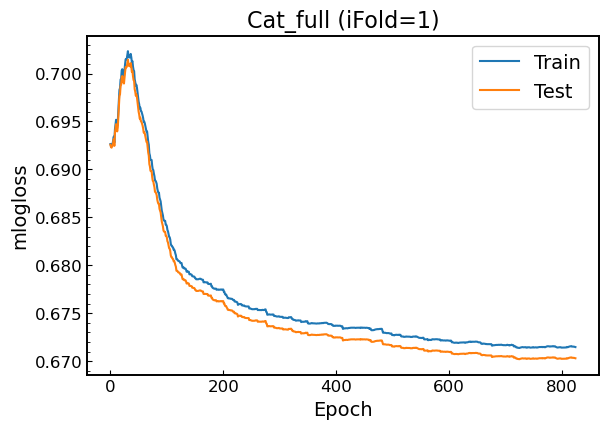

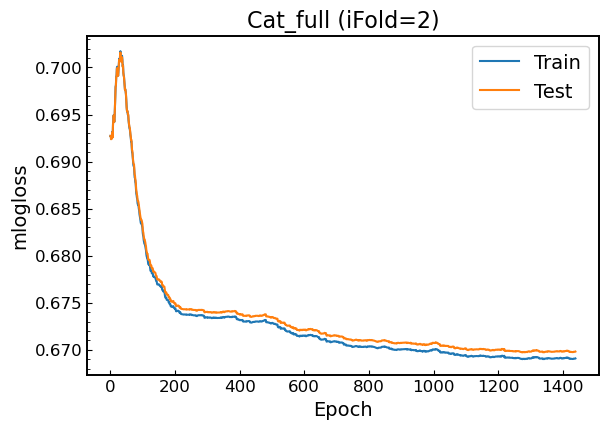

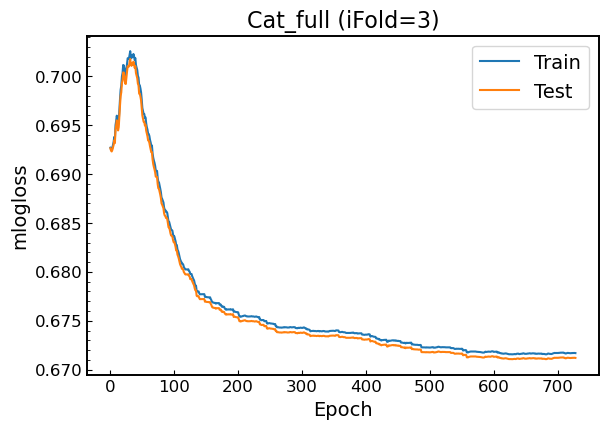

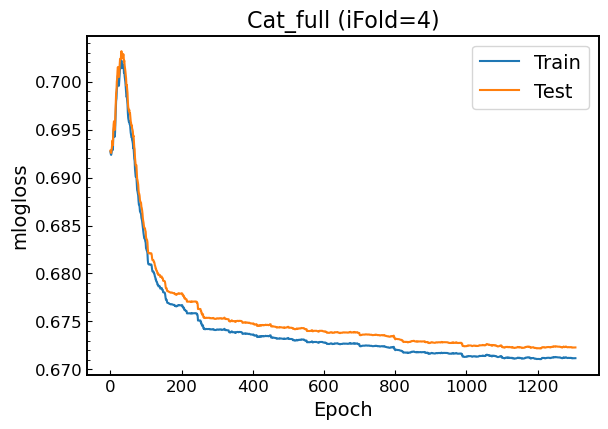

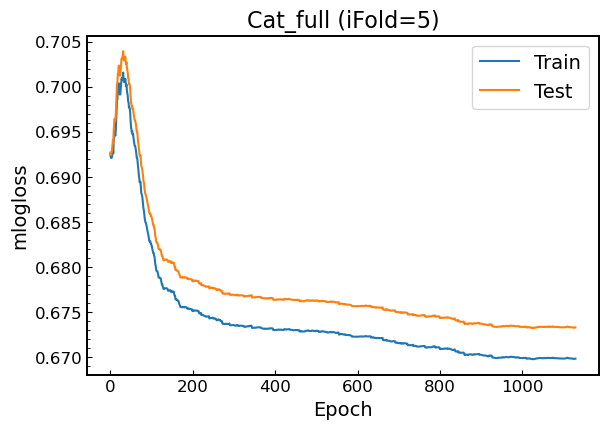

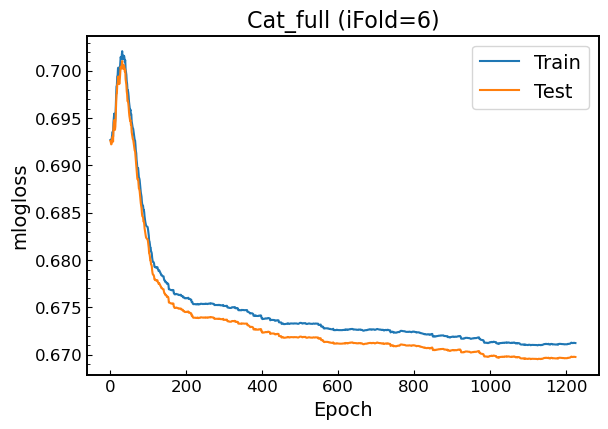

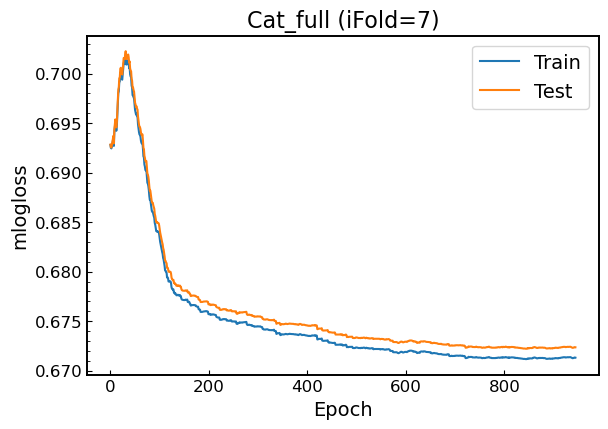

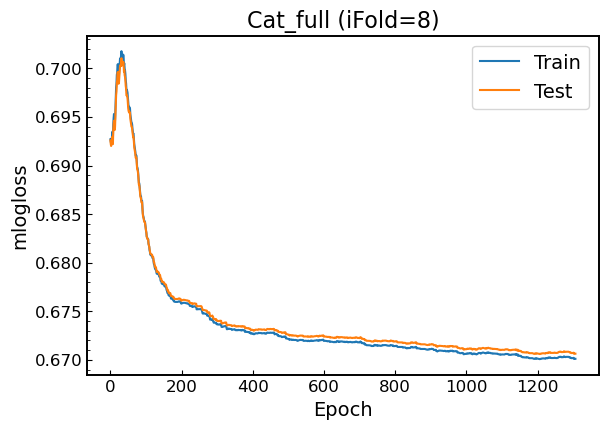

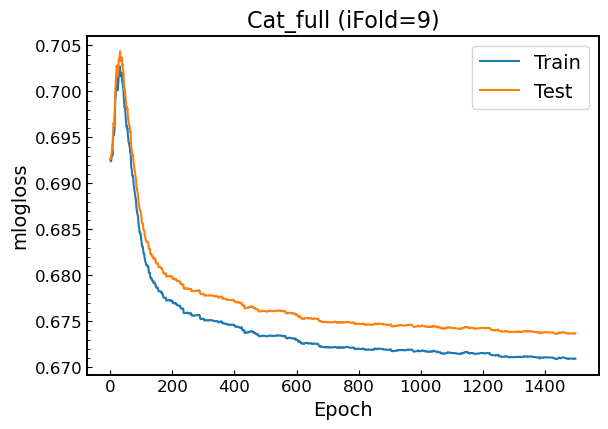

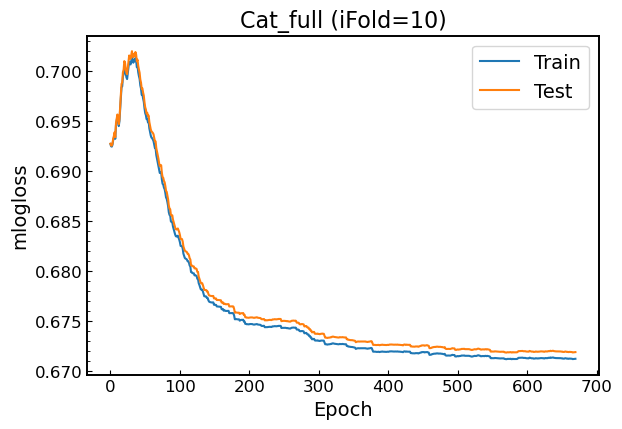

In [14]:
for category_ in xgbcvclassifiers:
    for fold_ in range(kFolds):
        plot_training_history(xgbcvclassifiers[category_][fold_][0], category_, fold_+1, param[0]["eval_metric"])

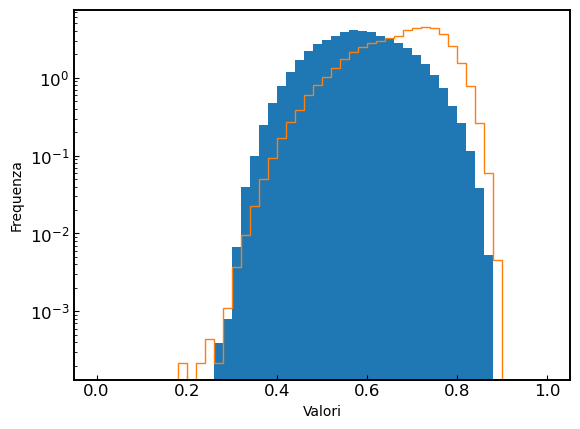

In [15]:
plt.hist(get_input_features(df, ["bdt_cv"], cuts="isMC>0"), bins=50, range=(0,1), density=True)  
plt.hist(get_input_features(df, ["bdt_cv"], cuts="isMC==0"), bins=50, range=(0,1), density=True, histtype='step')
plt.xlabel('Valori')
plt.ylabel('Frequenza')
plt.yscale('log')
plt.show()

isMC==0year==2022


<Figure size 640x480 with 0 Axes>

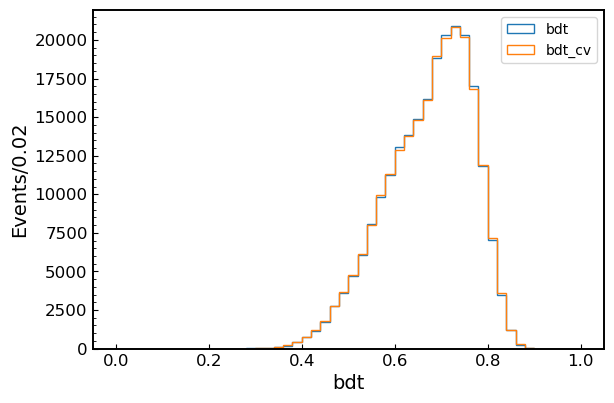

isMC==0year==2023


<Figure size 640x480 with 0 Axes>

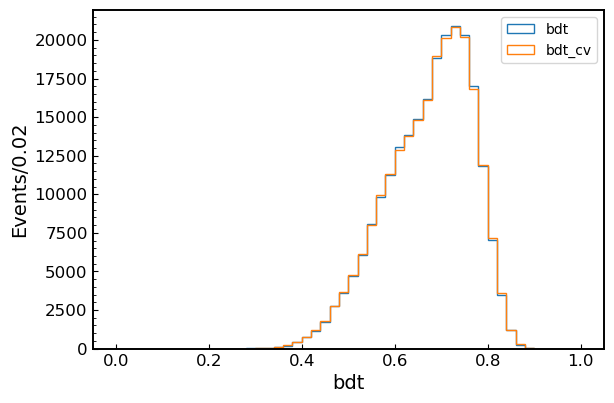

<Figure size 640x480 with 0 Axes>

In [16]:
for year in [2022, 2023]:
    for cat in categories_list:
        plt.clf()
        plt.figure(figsize=(6.6,4.4))
        try:
            bkg_sel = json_file[cat+"_bkg"]
            print(bkg_sel + f"year=={year}")
        except KeyError:
            bkg_sel = ""
        df_temp = df[df.eval(bkg_sel)]
        #for k in range(kFolds):
            #plt.hist(df_temp[f"bdt_fold{k}"], 
                     #bins=50, range=(0.0, 1.0), histtype='step', label = f"bdt_fold{k}")
        plt.hist(df_temp["bdt"], 
                     bins=50, range=(0.0, 1.0), histtype='step', label = f"bdt")
        plt.hist(df_temp["bdt_cv"], 
                     bins=50, range=(0.0, 1.0), histtype='step', label = f"bdt_cv")
        plt.xlabel('bdt', fontsize=14)
        plt.ylabel('Events/0.02', fontsize=14)
        #plt.yscale('log')
        plt.legend()
        plt.show()
        plt.savefig(out_dir+"/BDTscore_bkg_"+cat+".png")

dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
dict_keys(['year', 'bs_d2D', 'bs_d2Dsig', 'Pt_tripl', 'Eta_tripl'])
[{'year': 8.61, 'bs_d2D': 19.47, 'bs_d2Dsig': 17.99, 'Pt_tripl': 8.17, 'Eta_tripl': 6.22}, {'year': 8.0, 'bs_d2D': 19.52, 'bs_d2Dsig': 17.18, 'Pt_tripl': 8.3, 'Eta_tripl': 5.78}, {'year': 7.79, 'bs_d2D': 19.51, 'bs_d2Dsig': 18.51, 'Pt_tripl': 8.52, 'Et

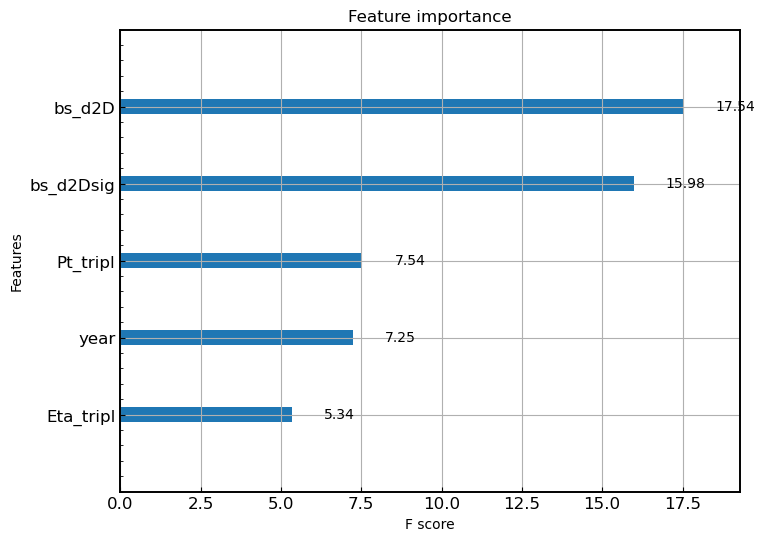

In [17]:
#feature importance
for category_ in xgbcvclassifiers:
    importance = []
    for fold_ in range(kFolds):
        # Get the booster from the xgbmodel
        booster = xgbcvclassifiers[category_][fold_][0].get_booster()
        booster.feature_names = training_variables
    
        # Get the importance dictionary (by gain) from the booster
        importance_temp = booster.get_score(importance_type="gain")
        # make your changes
        print(importance_temp.keys())
        for key in importance_temp.keys():
            importance_temp[key] = round(importance_temp[key],2)
        importance.append(importance_temp)

    #average importance across different folds
    importance_avg = importance[0]
    print(importance_avg.keys())
    print(importance)
    for key in importance_avg.keys():
        importance_avg[key]=0
        for fold_ in range(kFolds):
            importance_avg[key] += importance[fold_][key]/kFolds
        importance_avg[key] = round(importance_avg[key],2)
    
    # provide the importance dictionary to the plotting function
    ax = plot_importance(importance_avg, max_num_features=30, importance_type='gain', show_values=True)

    fig = ax.figure
    fig.set_size_inches(8, 6)
    fig.savefig(out_dir+"/feature_importance_"+category_+".png")